Upload & Unzip Dataset

In [1]:
from google.colab import files
import zipfile


uploaded = files.upload()


for fn in uploaded.keys():
    with zipfile.ZipFile(fn, 'r') as zip_ref:
        zip_ref.extractall("ecommerce_data")
print(" Files extracted successfully")


Saving Dataset.zip to Dataset.zip
 Files extracted successfully


Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)


Load the Three Datasets

In [4]:

item_properties = pd.read_csv("/content/ecommerce_data/Dataset/item_properties_part1.csv")
events = pd.read_csv("/content/ecommerce_data/Dataset/events.csv")
category_tree = pd.read_csv("/content/ecommerce_data/Dataset/category_tree.csv")

print("Item Properties Sample:")
display(item_properties.head())

print("Events Sample:")
display(events.head())

print("Category Tree Sample:")
display(category_tree.head())


Item Properties Sample:


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


Events Sample:


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


Category Tree Sample:


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


Data Cleaning & Preprocessing

In [5]:

item_properties['timestamp'] = pd.to_datetime(item_properties['timestamp'], unit='ms')
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')


item_properties.drop_duplicates(inplace=True)
events.drop_duplicates(inplace=True)
category_tree.drop_duplicates(inplace=True)

print(" Data cleaned successfully")


 Data cleaned successfully


Data Transformation (Join & Prepare)

In [7]:

category_props = item_properties[item_properties['property'] == 'categoryid'].copy()


category_props['value'] = pd.to_numeric(category_props['value'], errors='coerce')


latest_category = category_props.sort_values('timestamp').drop_duplicates('itemid', keep='last')


events_with_cat = events.merge(latest_category[['itemid','value']], on='itemid', how='left')
events_with_cat = events_with_cat.rename(columns={'value':'categoryid'})


events_final = events_with_cat.merge(category_tree, on='categoryid', how='left')

print(" Final merged dataset sample:")
display(events_final.head())


✅ Final merged dataset sample:


,timestamp,visitorid,event,itemid,transactionid,categoryid,parentid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,1173.0,805.0
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,NaN,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,NaN,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,NaN,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,NaN,NaN


**Exploratory Data Analysis (EDA)**

Distribution of Events

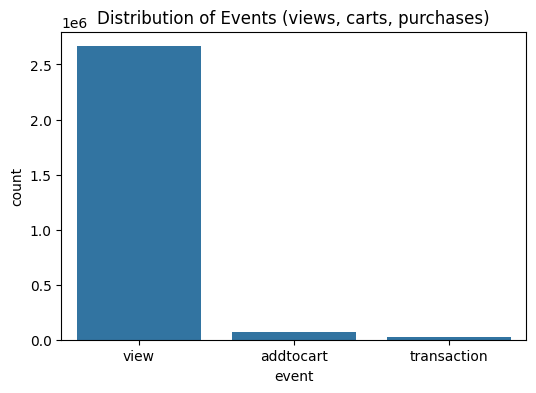

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x="event", data=events, order=events['event'].value_counts().index)
plt.title("Distribution of Events (views, carts, purchases)")
plt.show()


Daily Activity Trend

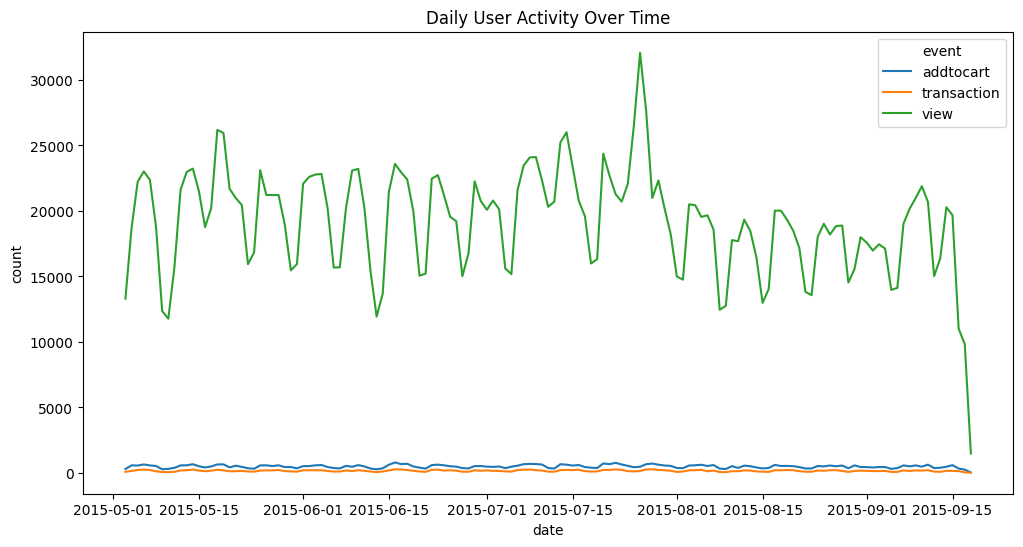

In [9]:
events['date'] = events['timestamp'].dt.date
daily_counts = events.groupby(['date','event']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.lineplot(x="date", y="count", hue="event", data=daily_counts)
plt.title("Daily User Activity Over Time")
plt.show()


Top Viewed Items

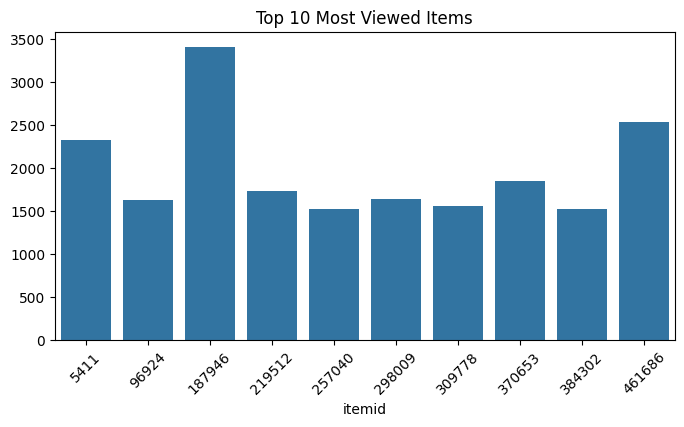

In [10]:
top_items = events[events['event']=="view"].itemid.value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_items.index, y=top_items.values)
plt.title("Top 10 Most Viewed Items")
plt.xticks(rotation=45)
plt.show()


**Key Behavioral Metrics**

Cart Abandonment Rate

In [11]:
views = events[events['event']=="view"].visitorid.nunique()
carts = events[events['event']=="addtocart"].visitorid.nunique()
purchases = events[events['event']=="transaction"].visitorid.nunique()

cart_abandonment_rate = (carts - purchases) / carts * 100 if carts>0 else 0
print(f"Cart Abandonment Rate: {cart_abandonment_rate:.2f}%")


Cart Abandonment Rate: 68.93%


Session Length Distribution

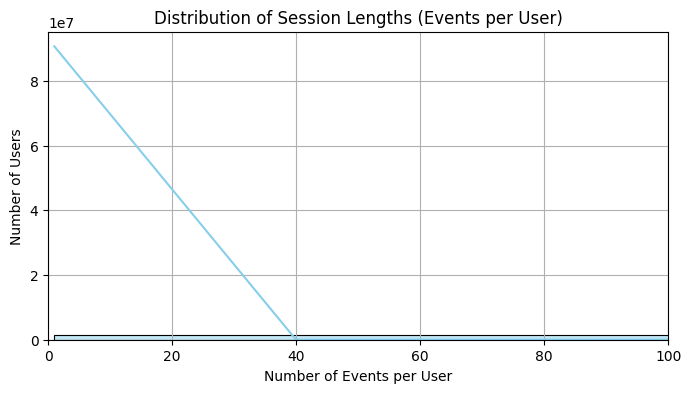

 Session Length Stats:
count    1.407580e+06
mean     1.957715e+00
std      1.257981e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      7.757000e+03
dtype: float64


In [25]:

session_length = events.groupby('visitorid').size()

plt.figure(figsize=(8,4))
sns.histplot(session_length, bins=50, kde=True, color="skyblue")

plt.title("Distribution of Session Lengths (Events per User)")
plt.xlabel("Number of Events per User")
plt.ylabel("Number of Users")
plt.xlim(0, 100)
plt.grid(True)
plt.show()


print(" Session Length Stats:")
print(session_length.describe())


Time-to-Purchase Analysis

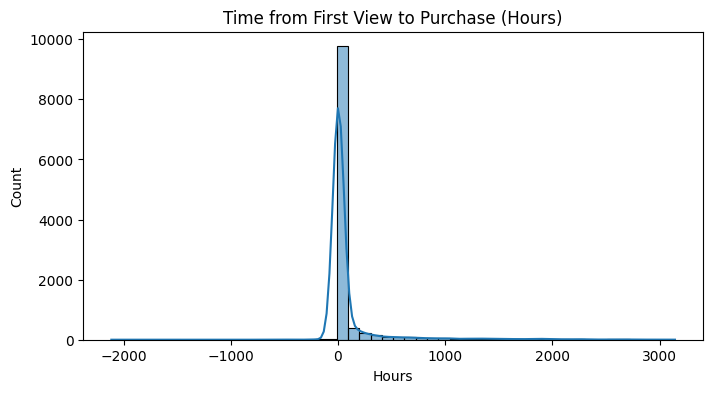

In [13]:
purchase_times = events[events['event']=="transaction"].groupby('visitorid')['timestamp'].min()
view_times = events[events['event']=="view"].groupby('visitorid')['timestamp'].min()

time_to_purchase = (purchase_times - view_times).dropna().dt.total_seconds() / 3600

plt.figure(figsize=(8,4))
sns.histplot(time_to_purchase, bins=50, kde=True)
plt.title("Time from First View to Purchase (Hours)")
plt.xlabel("Hours")
plt.show()


**End-to-End Pipeline: Batch vs Streaming**

Batch Processing Simulation

In [14]:

def batch_ingestion(events_df, batch_size=50000):
    batches = [events_df.iloc[i:i+batch_size] for i in range(0, len(events_df), batch_size)]
    print(f" Total batches created: {len(batches)}")
    return batches


batches = batch_ingestion(events, batch_size=50000)


batch1 = batches[0]
print("First Batch Sample:")
display(batch1.head())


 Total batches created: 56
First Batch Sample:


,timestamp,visitorid,event,itemid,transactionid,date
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,2015-06-02
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,2015-06-02
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,2015-06-02
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,2015-06-02
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,2015-06-02


Streaming Processing Simulation

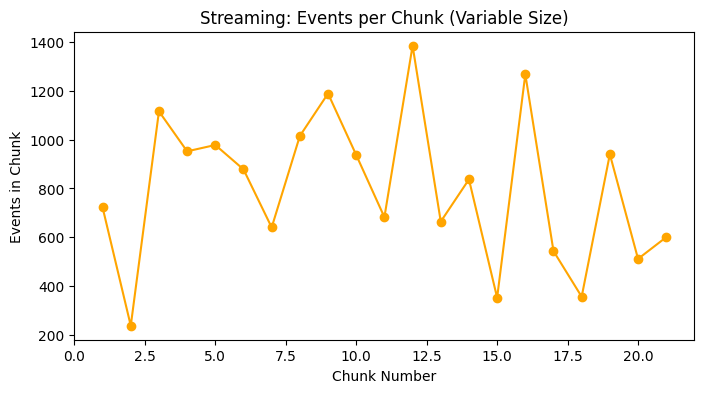

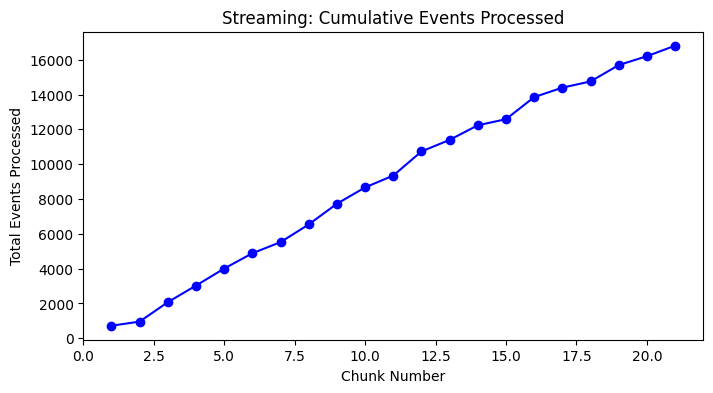

In [21]:
import numpy as np
import matplotlib.pyplot as plt

events_shuffled = events.sample(frac=1, random_state=42).reset_index(drop=True)


def stream_ingestion_variable(events_df, min_chunk=200, max_chunk=1500):
    i = 0
    while i < len(events_df):
        chunk_size = np.random.randint(min_chunk, max_chunk)
        yield events_df.iloc[i:i+chunk_size]
        i += chunk_size


chunk_sizes = []
cumulative_events = []

total = 0
for i, chunk in enumerate(stream_ingestion_variable(events_shuffled)):
    size = len(chunk)
    total += size
    chunk_sizes.append(size)
    cumulative_events.append(total)

    if i == 20:
        break


plt.figure(figsize=(8,4))
plt.plot(range(1, len(chunk_sizes)+1), chunk_sizes, marker='o', color='orange')
plt.title("Streaming: Events per Chunk (Variable Size)")
plt.xlabel("Chunk Number")
plt.ylabel("Events in Chunk")
plt.show()


plt.figure(figsize=(8,4))
plt.plot(range(1, len(cumulative_events)+1), cumulative_events, marker='o', color='blue')
plt.title("Streaming: Cumulative Events Processed")
plt.xlabel("Chunk Number")
plt.ylabel("Total Events Processed")
plt.show()


Unified Processing Function

In [16]:
def process_events(df):

    event_counts = df['event'].value_counts().to_dict()
    return event_counts


print("Batch Processing Results (Batch 1):", process_events(batch1))


for i, chunk in enumerate(stream_ingestion(events, chunk_size=2000, delay=0)):
    print(f"Streaming Chunk {i+1}:", process_events(chunk))
    if i == 2:
        break


Batch Processing Results (Batch 1): {'view': 48419, 'addtocart': 1149, 'transaction': 432}
Streaming Chunk 1: {'view': 1937, 'addtocart': 50, 'transaction': 13}
Streaming Chunk 2: {'view': 1926, 'addtocart': 52, 'transaction': 22}
Streaming Chunk 3: {'view': 1928, 'addtocart': 54, 'transaction': 18}


Compare Batch vs Streaming Performance

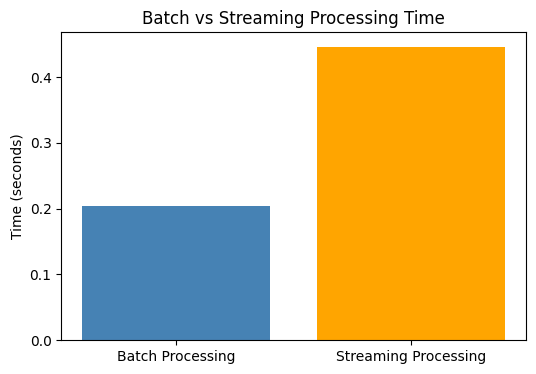

In [19]:
import matplotlib.pyplot as plt


times = {
    "Batch Processing": batch_time,
    "Streaming Processing": stream_time
}


plt.figure(figsize=(6,4))
plt.bar(times.keys(), times.values(), color=['steelblue','orange'])
plt.ylabel("Time (seconds)")
plt.title("Batch vs Streaming Processing Time")
plt.show()


Visualize Batch vs Streaming Event Counts

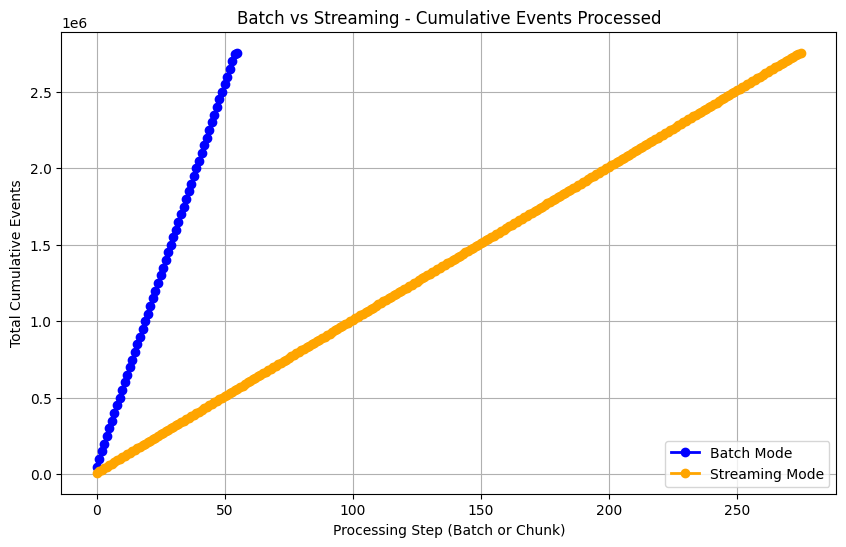

In [24]:

batch_df = pd.DataFrame(batch_results).fillna(0)
stream_df = pd.DataFrame(stream_results).fillna(0)


batch_cumulative = batch_df.cumsum().sum(axis=1)
stream_cumulative = stream_df.cumsum().sum(axis=1)


plt.figure(figsize=(10,6))
plt.plot(batch_cumulative.index, batch_cumulative.values, label="Batch Mode", linewidth=2, color="blue", marker="o")
plt.plot(stream_cumulative.index, stream_cumulative.values, label="Streaming Mode", linewidth=2, color="orange", marker="o")

plt.title("Batch vs Streaming - Cumulative Events Processed")
plt.xlabel("Processing Step (Batch or Chunk)")
plt.ylabel("Total Cumulative Events")
plt.legend()
plt.grid(True)
plt.show()


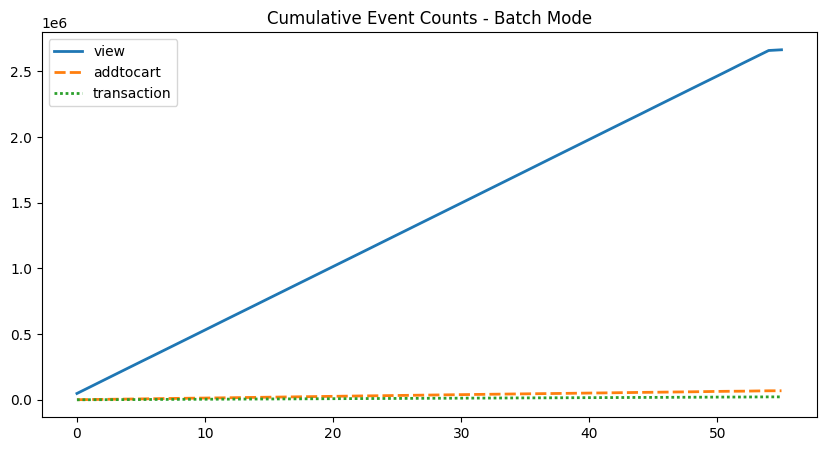

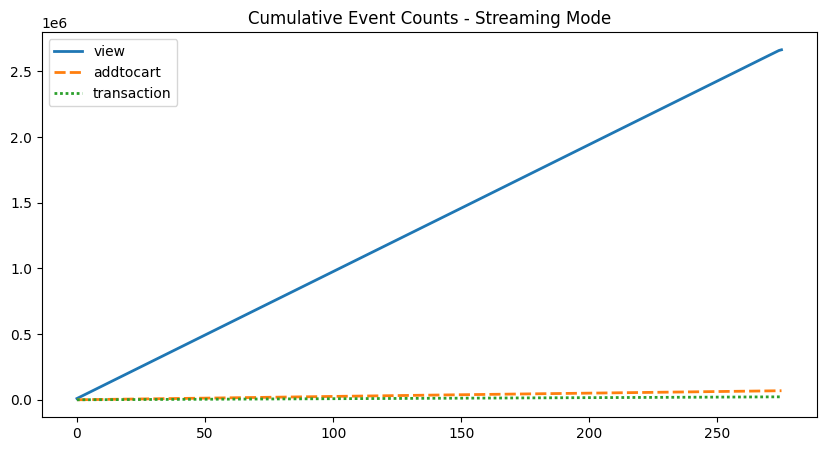

In [18]:

batch_results = [process_events(batch) for batch in batches]
stream_results = [process_events(chunk) for chunk in stream_ingestion(events, chunk_size=10000, delay=0)]


batch_df = pd.DataFrame(batch_results).fillna(0)
stream_df = pd.DataFrame(stream_results).fillna(0)

plt.figure(figsize=(10,5))
sns.lineplot(data=batch_df.cumsum(), palette="tab10", linewidth=2)
plt.title("Cumulative Event Counts - Batch Mode")
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(data=stream_df.cumsum(), palette="tab10", linewidth=2)
plt.title("Cumulative Event Counts - Streaming Mode")
plt.show()
